In [1]:
!pip install ujson 
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f8/8c/5274ba7b4df814c87a8840a58e2b1dae6a489f49c3b0fad2d15f1e41d47b/ujson-5.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [17]:
import sys 
sys.path.append('../')

In [18]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [19]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load train and validation data 

In [49]:
time_start = time.time()

data_args = {'stage': 'train',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], # ['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 150}
train_data = dataset_lvis.LVISData(**data_args)

print(f'Time taken to initialize train set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 618 positive set images
loaded 898 negative set images
loaded 25 non-exhaustive set images
Loaded 1489 images!
class 1 has 71 positive and 150 negative images
class 2 has 9 positive and 150 negative images
class 3 has 233 positive and 150 negative images
class 4 has 199 positive and 150 negative images
class 5 has 8 positive and 150 negative images
class 6 has 73 positive and 150 negative images
995 annotations found!
stage:  train
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  /home/Datasets/coco/images/train2017
Time taken to initialize train set: 41.61019277572632


In [50]:
time_start = time.time() 
data_args = {'stage': 'val',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], #['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 150}
val_data = dataset_lvis.LVISData(**data_args)
print(f'Time taken to initialize val set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 119 positive set images
loaded 839 negative set images
loaded 2 non-exhaustive set images
Loaded 953 images!
class 1 has 17 positive and 150 negative images
class 2 has 1 positive and 150 negative images
class 3 has 46 positive and 150 negative images
class 4 has 39 positive and 150 negative images
class 5 has 2 positive and 111 negative images
class 6 has 12 positive and 150 negative images
166 annotations found!
stage:  val
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  /home/Datasets/coco/images/train2017
Time taken to initialize val set: 3.6433255672454834


# Fine-tuning the model

In [52]:
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Set up DataLoaders

In [53]:

train_loader = torch.utils.data.DataLoader(
 train_data, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

val_loader = torch.utils.data.DataLoader(
 val_data, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


# Initialize Model + Model params

In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 7

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model

In [43]:
num_epochs = 2
time_start = time.time() 


train_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
val_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])

loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss']


for epoch in range(num_epochs):
    model.train()
    
    train_loss = dict.fromkeys(loss_types, 0) 
    val_loss = dict.fromkeys(loss_types, 0) 
    
    """
    Train 
    """
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        losses = sum(loss for loss in loss_dict.values())
        
        #save losses
        for key in loss_types:
            if key != 'total_loss':
                train_loss[key] += loss_dict[key].item()
            else: 
                train_loss['total_loss'] += losses.item()
                

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [train_loss['loss_classifier']/(batch_num+1)],
          'loss_box_reg' : [train_loss['loss_box_reg']/(batch_num+1)],
           'loss_mask': [train_loss['loss_mask']/(batch_num+1)],
           'loss_objectness': [train_loss['loss_objectness']/(batch_num+1)],
           'loss_rpn_box_reg': [train_loss['loss_rpn_box_reg']/(batch_num+1)],
            'total_loss': [train_loss['total_loss']/(batch_num+1)] 
          })     

    train_loss_df = pd.concat([train_loss_df, row], ignore_index = True, axis = 0)
    
    print(f"Training loss after {epoch} epochs: {train_loss['total_loss']}")

    
    """
    Validation
    """
    with torch.no_grad():
        for batch_num, (idx, X, y) in enumerate(val_loader):
            X = X.to(device)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            loss_dict = model(X, y) 
            
            losses_val = sum(loss for loss in loss_dict.values())
            
            #save losses
            for key in loss_types:
                if key != 'total_loss':
                    val_loss[key] += loss_dict[key].item()
                else: 
                    val_loss['total_loss'] += losses_val.item()
                    
        row = pd.DataFrame({'epoch': [epoch],
                          'loss_classifier': [val_loss['loss_classifier']/(batch_num+1)],
                          'loss_box_reg' : [val_loss['loss_box_reg']/(batch_num+1)],
                           'loss_mask': [val_loss['loss_mask']/(batch_num+1)],
                           'loss_objectness': [val_loss['loss_objectness']/(batch_num+1)],
                           'loss_rpn_box_reg': [val_loss['loss_rpn_box_reg']/(batch_num+1)],
                            'total_loss': [val_loss['total_loss']/(batch_num+1)] 
                          })
        val_loss_df = pd.concat([val_loss_df, row], ignore_index = True, axis = 0)

    print(f"Validation loss after {epoch} epochs: {val_loss['total_loss']}") 
    print(f'Time elapsed for {epoch} epochs: {time.time()-time_start}') 

      
    """
    Save checkpoints and losses every 5 epoch
    """
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch,
                        "ds_args" : data_args
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        helper.save_checkpoint(checkpoint, fname)
        print(f'Time elapsed after {epoch} epochs: {time.time()-time_start}')  
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))

    
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

Training loss after 0 epochs: 55.24518710374832
Validation loss after 0 epochs: 7.716893404722214
Time elapsed for 0 epochs: 97.67824578285217
Saved checkpoint model_0_epochs.pth!
Time elapsed after 0 epochs: 98.79443454742432
Training loss after 1 epochs: 35.87267026305199
Validation loss after 1 epochs: 7.1240220963954926
Time elapsed for 1 epochs: 198.05672240257263
Saved model model.pth!
Time elapsed for 2 epochs: 3.31 min


# Plot loss 

,train_loss,val_loss
0,0.920753,0.593607
1,0.597878,0.548002


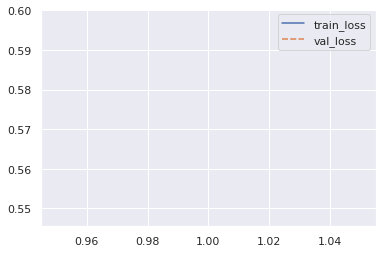

In [44]:
new_df = pd.DataFrame() 
#new_df['epoch'] = train_loss_df['epoch'] 
new_df['train_loss'] = train_loss_df['total_loss'] 
new_df['val_loss'] = val_loss_df['total_loss'] 

sns.lineplot(data = new_df[1:])
new_df


In [47]:
train_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.240526,0.123334,0.46842,0.063658,0.024815,0.920753
1,1,0.145721,0.151916,0.262939,0.022273,0.015029,0.597878


In [48]:
val_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.132092,0.117159,0.283429,0.03464,0.026286,0.593607
1,1,0.116492,0.136724,0.247314,0.030745,0.016726,0.548002
